The final few layers of a language transformer model are the unembedding. The job of these layers is to turn a vector (in the "model space") into a probability distribution over tokens.

In the case of gpt2-small, the model space is 768-dimensional and the token vocabulary size is 50257.

This consists of:
- a learned unembedding _matrix_
- a learned _bias vector_, which outputs _logits_
- a fixed _softmax layer_, which outputs _probabilities_

Let's go in reverse and look at the softmax layer first. We'll use a toy example for illustration with a very small vocabulary, but the concepts generalize to a larger vocabulary.

In [24]:
import torch

# Our example vocabulary
vocab = ['cat','dog','pig','squirrel','the','of','and']

# The number of words in the vocabulary (or the "dimension" of the logit and probability spaces)
d_V = len(vocab)
print(f"Vocab size = {d_V}")

# Generate a random vector of logits (the input to softmax). The generator just makes sure this returns the same answer each time
generator = torch.Generator()
generator.manual_seed(12345)
logits = torch.normal(mean=0.0, std=1.0, size=(d_V,), generator=generator)

print('Logits =', logits)

# See which word has the greatest logit. This will be the "most likely" in the probability distribution
# We print both the index and the corresponding string token
most_likely = torch.argmax(logits).item()
print(f'Most likely =', most_likely, vocab[most_likely])

# Now put it through softmax to obtain the probabilities
probs = torch.nn.functional.softmax(logits, dim=0)

# Enumerate the probability vector, showing corresponding tokens
def print_example_probs(probs):
    print('Probs =', probs)
    for i in range(d_V):
        print('    ', f'{vocab[i]:10}', probs[i].item())
print_example_probs(probs)

Vocab size = 7
Logits = tensor([ 1.4271, -1.8701, -1.1962, -2.0440, -0.4560, -1.4295, -0.7175])
Most likely = 0 cat
Probs = tensor([0.6815, 0.0252, 0.0495, 0.0212, 0.1037, 0.0392, 0.0798])
     cat        0.6815164685249329
     dog        0.025206468999385834
     pig        0.049450863152742386
     squirrel   0.021183840930461884
     the        0.10366861522197723
     of         0.03916327282786369
     and        0.07981050759553909


Softmax has some interesting properties. In particular:
- Adding a uniform value to each logit leaves the output of softmax unchanged. Softmax only cares about how much things are bigger and smaller than each other, not their actual values
- Scaling the vector up (multiplying by a real number >1) will increase the certainty, i.e. make the most likely value more likely
- Scaling the vector down (multiplying by a real number <1) will have the opposite effect, making the distribution flatter.

In [20]:
print('Original:')
print(f'Probs =', torch.nn.functional.softmax(logits, dim=0))
print()
print('Adding 17 elementwise (this comes out the same):')
print(f'Probs =', torch.nn.functional.softmax(logits + 17, dim=0))
print()
print('Multiplying by 2 (makes it more certain):')
print(f'Probs =', torch.nn.functional.softmax(logits * 2, dim=0))
print()
print('Multiplying by 0.5 (makes it less certain):')
print(f'Probs =', torch.nn.functional.softmax(logits * 0.5, dim=0))

Original:
Probs = tensor([0.6815, 0.0252, 0.0495, 0.0212, 0.1037, 0.0392, 0.0798])

Adding 17 elementwise (this comes out the same):
Probs = tensor([0.6815, 0.0252, 0.0495, 0.0212, 0.1037, 0.0392, 0.0798])

Multiplying by 2 (makes it more certain):
Probs = tensor([9.5442e-01, 1.3056e-03, 5.0250e-03, 9.2214e-04, 2.2084e-02, 3.1517e-03,
        1.3089e-02])

Multiplying by 0.5 (makes it less certain):
Probs = tensor([0.3832, 0.0737, 0.1032, 0.0676, 0.1494, 0.0918, 0.1311])


In [22]:
print("Note that if the softmax layer is given a vector of zeros, it will output equal probability for every token")
print("This is ok in our toy example, but in the real dictionary a lot of the tokens are very rare/complete garbage.")
print("We don't want to output equal probability for those.")
zeros = torch.zeros((d_V,))
print(f'Probs =', torch.nn.functional.softmax(zeros))

Note that if the softmax layer is given a vector of zeros, it will output equal probability for every token
This is ok in our toy example, but in the real dictionary a lot of the tokens are very rare/complete garbage.
We don't want to output equal probability for those.
Probs = tensor([0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429])


Now that we understand softmax, let's look at the previous layers.

Because some tokens are a lot more probable than others (in general), it helps to have a "bias layer" that adds the approximate token commonness to each token, before the softmax is applied. This can be "overridden" in some sense - given a sufficiently large vector identifying one particular token, that token will still win even if the bias layer is against it.

In [31]:
bias = torch.tensor([1.0, 1.0, 0.5, -0.5, 2.0, 2.0, 2.0])

print("Original (without bias vector):")
print_example_probs(torch.nn.functional.softmax(logits, dim=0))

print()
print("With bias vector added:")
print_example_probs(torch.nn.functional.softmax(logits + bias, dim=0))

print()
print("If the original vector is large enough, it can overcome the bias and the squirrel wins")
big_squirrel_logits = torch.tensor([0, 0, 0, 7, 0, 0, 0])
print_example_probs(torch.nn.functional.softmax(big_squirrel_logits + bias, dim=0))

Original (without bias vector):
Probs = tensor([0.6815, 0.0252, 0.0495, 0.0212, 0.1037, 0.0392, 0.0798])
     cat        0.6815164685249329
     dog        0.025206468999385834
     pig        0.049450863152742386
     squirrel   0.021183840930461884
     the        0.10366861522197723
     of         0.03916327282786369
     and        0.07981050759553909

With bias vector added:
Probs = tensor([0.5061, 0.0187, 0.0223, 0.0035, 0.2093, 0.0791, 0.1611])
     cat        0.506083607673645
     dog        0.01871793530881405
     pig        0.022272685542702675
     squirrel   0.003510014619678259
     the        0.2092607021331787
     of         0.07905318588018417
     and        0.1611018180847168

If the original vector is large enough, it can overcome the bias and the squirrel wins
Probs = tensor([0.0039, 0.0039, 0.0024, 0.9579, 0.0106, 0.0106, 0.0106])
     cat        0.0039146095514297485
     dog        0.0039146095514297485
     pig        0.0023743310011923313
     squirrel   0.

It's important not to forget the bias vector is there. But, we're not going to focus on it here.

Instead, we'll be looking at the weights matrix. This can be thought of as a linear map from the model's internal vector space to the token logit space.

In this artificial example, we'll be pretending the model space is two dimensional. This is unrealistic but will help with visualizations.

torch.Size([2, 7])


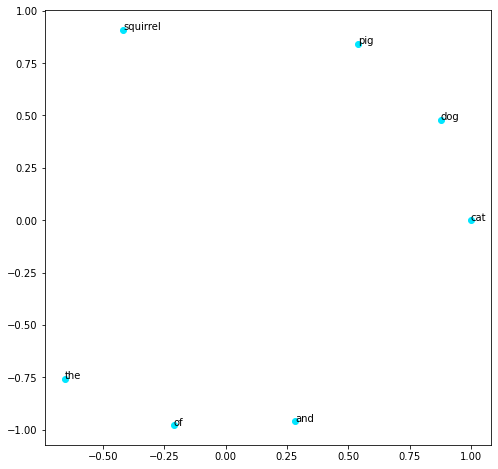

In [48]:
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

ts = [0, 0.5, 1, 2, 4, 4.5, 5]

# The weights matrix
M_to_V = torch.tensor([[math.cos(t), math.sin(t)] for t in ts]).T
print(M_to_V.shape)

plt.scatter(M_to_V[0,:], M_to_V[1,:], color=(0,0.9,1))
for t in range(d_V):
    plt.text(M_to_V[0,t], M_to_V[1,t], vocab[t])